# Importing libraries and reading in file

In [2]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 67kB/s 
     |████████████████████████████████| 204kB 41.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=67440d5b7883c5dd5f5bb85b3a1045711704aa79365321a43077938a5daf60fc
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

In [4]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import NaiveBayes
from pyspark import SparkContext

if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("Detecting-Malicious-URL App")\
        .getOrCreate()

#Reading in the URL file and storing into dataframe
data_df = spark.read.csv(path='/content/dataset.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)

data_df.groupby('label').count().toPandas()

,label,count
0,1,56937
1,0,1000000


In [5]:
data_df.head(9)

[Row(url='http://br-ofertasimperdiveis.epizy.com/produto.php?linkcompleto=iphone-6-plus-apple-64gb-cinza-espacial-tela-5-5-retina-4g-camera-8mp-frontal-ios-10-proc.-m8/p/2116558/te/ipho/&amp;id=10', label=1),
 Row(url='https://semana-da-oferta.com/produtos.php?id=5abad0c01d149', label=1),
 Row(url='https://scrid-apps-creacust-sslhide90766752024.cread-squi.com/hider_reo/', label=1),
 Row(url='http://my-softbank-security.com/wap_login.htm', label=1),
 Row(url='http://www.my-softbank-security.com/wap_login.htm', label=1),
 Row(url='http://diadesaldaolu.infomando.com', label=1),
 Row(url='https://sites.google.com/site/helpsettingsrecoveryfbus2018/', label=1),
 Row(url='http://protvinowifi.ru/', label=1),
 Row(url='http://socset222.96.lt/', label=1)]

# Under Sample Unbalanced Datasets

In [6]:

malicious = data_df.filter("label = 1")
bening = data_df.filter("label = 0")

#malicious.count()
#bening.count()

sampleRatio = malicious.count() / data_df.count()
#print("sampleRatio: %g" %sampleRatio)
sample_bening = bening.sample(False, sampleRatio)

sampled = malicious.unionAll(sample_bening)

sampled.groupby('label').count().toPandas()



,label,count
0,1,56937
1,0,53741


# Data Ingestion and Vectorization

In [7]:
#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = CountVectorizer(inputCol=regexTokenizer.getOutputCol(), outputCol="rawfeatures", vocabSize=10000, minDF=5)

#
idf = IDF(inputCol=countVectors.getOutputCol(), outputCol="features") 

#create the pipline 
pipeline = Pipeline(stages=[regexTokenizer, countVectors, idf ])


# Fit the pipeline to training documents.
# Pass 'sampled' in the param to set Balanced datasets
pipelineFit = pipeline.fit(sampled)

#Transform the pipeline to dataset
# Pass 'sampled' in the param to set Balanced datasets
dataset = pipelineFit.transform(sampled)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("\nTraining Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))

dataset.show(5)


Training Dataset Count: 88633
Test Dataset Count: 22045
Total Dataset Count: 110678
+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(6949,[0,1,2,3,18...|(6949,[0,1,2,3,18...|
|https://semana-da...|    1|[https, semana, d...|(6949,[0,3,6,18,1...|(6949,[0,3,6,18,1...|
|https://scrid-app...|    1|[https, scrid, ap...|(6949,[0,6,845],[...|(6949,[0,6,845],[...|
|http://my-softban...|    1|[http, my, softba...|(6949,[0,1,29,159...|(6949,[0,1,29,159...|
|http://www.my-sof...|    1|[http, www, my, s...|(6949,[0,1,4,29,1...|(6949,[0,1,4,29,1...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [8]:
dataset['Words']

Column<b'Words'>

In [9]:
trainingData.groupby('label').count().toPandas()

,label,count
0,1,45609
1,0,43024


# Logistic Regression


True Positives: 10725
True Negative: 10715
False Positive: 2
False Negative: 603
Total: 22045

Accuracy: 97.2556
F-Score: 97.2568581
Recall: 94.6769
Precision: 99.9814


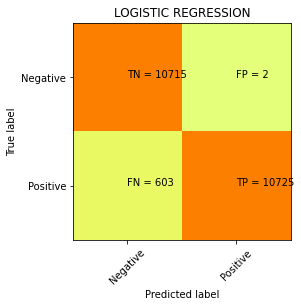

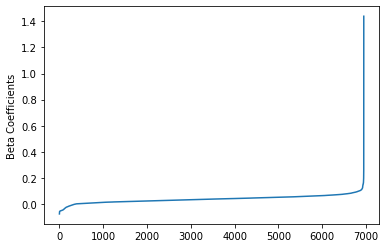

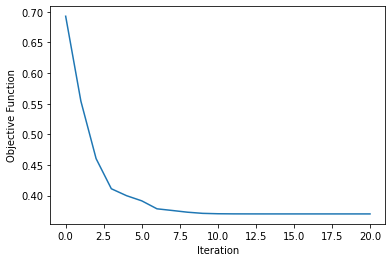

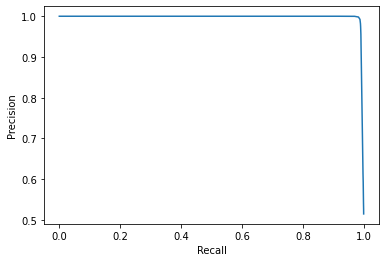

areaUnderROC: 0.9958162478142485


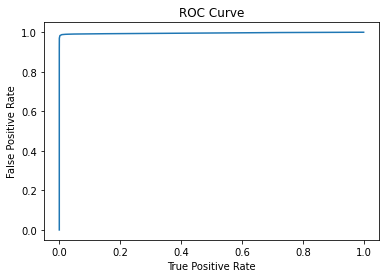

+---------------+---------------+
|      threshold|      F-Measure|
+---------------+---------------+
|0.9917329569...|0.0159648512...|
|0.9857424823...|0.0307419960...|
|0.9808421215...|0.0444625476...|
|0.9759901084...|0.0572487380...|
|0.9714392730...|0.0736188545...|
|0.9672005013...|0.0871516346...|
|0.9635436464...|0.1038124142...|
|0.9599367968...|0.1163424606...|
|0.9562765156...|0.1318505775...|
|0.9529013296...|0.1451839199...|
+---------------+---------------+
only showing top 10 rows



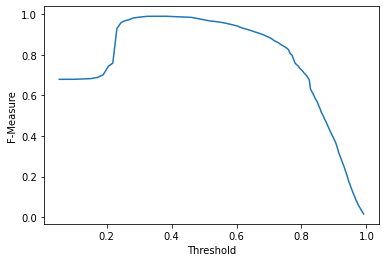

+-------------------------------------------+-----+----------+
|                                        url|label|prediction|
+-------------------------------------------+-----+----------+
|    without-prescription-buy-prednisone.com|    0|       0.0|
|        prednisone-no-prescription-buy.mobi|    0|       0.0|
|                   cheapest-20mg-cialis.org|    0|       0.0|
|             20mg-cheapestprice-levitra.org|    0|       0.0|
|             cheapestprice-buy-propecia.org|    0|       0.0|
|                   cialis-canadian-20mg.org|    0|       0.0|
|amoxicillin-amoxil-without-prescription.net|    0|       0.0|
|                   20mg-cheapest-cialis.xyz|    0|       0.0|
|                         independent.gov.uk|    0|       0.0|
|                     buyonline-levitra.mobi|    0|       0.0|
+-------------------------------------------+-----+----------+
only showing top 10 rows



In [10]:
#==============[ LOGISTIC REGRESSION ]=========================
r = 0.0
p = 0.0
a = 0.0
f1 = 0.0
avg_r = 0.0
avg_p = 0.0
avg_a = 0.0
avg_f1 = 0.0
total_r = 0.0
tofal_p = 0.0
total_a = 0.0
total_f1 = 0.0


# Build logistic regresssion model
for i in range(1,6):
    
    dataset = pipelineFit.transform(sampled)

    #randomly split the dataset to traning and testing 80%, 20% respectively
    #(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
    #print("\n")
    #trainingData.groupby('label').count().toPandas()
    
    lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")
    # Train model using logisitic regression
    lrModel = lr.fit(trainingData)

    #Doing the prediction using test data
    #Label is not used in test data
    predictions = lrModel.transform(testData)

df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("\nTrue Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2


print("\nAccuracy: %g" %(a*100))
print("F-Score: %f1" %(f1*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))



#===========================ploting================================================================

#plt.clf()
lr_predictions = lrModel.transform(testData)

y_actu = lr_predictions.select("label").toPandas()
y_pred = lr_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('LOGISTIC REGRESSION')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#===============================================================

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

#Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Set the model threshold to maximize F-Measure
trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

predictions.filter(predictions['prediction'] == 0) \
    .select("url", "label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 80)
    
#Precision measures the percentage of URLs flagged as malicious that were correctly classified
#Recall measures the percentage of actual Malicious URLs that were correctly classified

# Naive Bayes

Test: Area Under ROC: 0.9687272038682405
True Positives: 10833
True Negative: 10515
False Positive: 202
False Negative: 495
Total: 22045
F-Score: 96.8832451

Accuracy: 96.8383
Recall: 95.6303
Precision: 98.1695


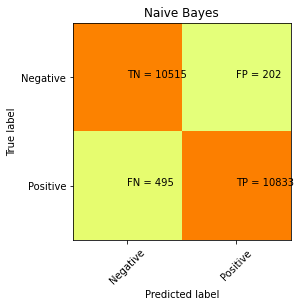

In [12]:

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial",)

# train the model
model = nb.fit(trainingData)

# select example rows to display.
predictions = model.transform(testData)


# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#===========================
df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("True Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2
print("F-Score: %f1" %(f1*100))

print("\nAccuracy: %g" %(a*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))


#===========================ploting

#plt.clf()
nb_predictions = model.transform(testData)

y_actu = nb_predictions.select("label").toPandas()
y_pred = nb_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Naive Bayes')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# Linear Support Vector Machine

Root Mean Squared Error (RMSE) on test data = 0.129553
True Positives: 10985
True Negative: 10690
False Positive: 27
False Negative: 343
Total: 22045
F-Score: 98.3437781

Accuracy: 98.3216
Recall: 96.9721
Precision: 99.7548


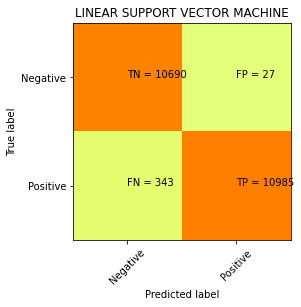

In [13]:
#==============[ Linear Support Vector Machine ]=====================

for i in range(1, 2):
    

    lsvc = LinearSVC(maxIter=10, regParam=0.3)

    # Fit the model
    lsvcModel = lsvc.fit(trainingData)

    predictions = lsvcModel.transform(testData)

    #predictions.select("url", "label", "prediction").show(n=5, truncate = 100)

    # Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate model
    evaluator = BinaryClassificationEvaluator()
    accuracy = evaluator.evaluate(predictions)

    
    #================================================================
    df = predictions.select('prediction', 'label')
    predictionAndLabels=df.rdd

    metrics = MulticlassMetrics(predictionAndLabels) 

    

    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    print("True Positives: %g" % tp)
    print("True Negative: %g" % tn)
    print("False Positive: %g" % fp)
    print("False Negative: %g" % fn)

    print("Total: %g" % (df.count()))

    r = float(tp)/(tp + fn)
    p = float(tp) / (tp + fp)
    a = float(tp + tn) / (tp + fp + tn + fn)
    f1 = float(p*r)/(p+r) * 2
    print("F-Score: %f1" %(f1*100))
    
    print("\nAccuracy: %g" %(a*100))
    print("Recall: %g" %(r*100))
    print("Precision: %g" %(p*100))
  

#=============================================================
    
    #==================[ Confusing Matrix Calculation and Plotting ]
    lsvm_predictions = lsvcModel.transform(testData)


    y_actu = lsvm_predictions.select("label").toPandas()
    y_pred = lsvm_predictions.select("prediction").toPandas()

    cm = confusion_matrix(y_actu, y_pred)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('LINEAR SUPPORT VECTOR MACHINE')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    #TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    

# One-vs-Rest Classifier (One-vs-All )

Test Error = 0.00807439

Accuracy on Test Data = 99.1926
True Positives: 11166
True Negative: 10701
False Positive: 16
False Negative: 162
Total: 22045
F-Score: 99.2092401
Recal: 98.5699
Precision: 99.8569
Accuracy: 99.1926


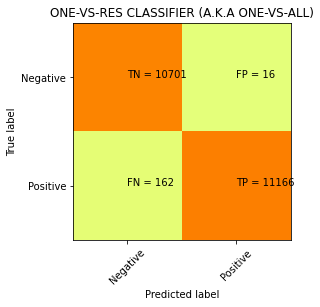

In [14]:
#==============[ One-vs-Rest classifier (a.k.a. One-vs-All ]=====================

for i in range(1, 2):
    
    # instantiate the base classifier.
    #lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
    lr = LogisticRegression(maxIter=10, regParam=0.001, elasticNetParam=0, tol=1E-6, fitIntercept=True )

    # instantiate the One Vs Rest Classifier.
    ovr = OneVsRest(classifier=lr)

    # train the multiclass model.
    ovrModel = ovr.fit(trainingData)

    # score the model on test data.
    predictions = ovrModel.transform(testData)

    # obtain evaluator.
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    # compute the classification error on test data.
    accuracy = evaluator.evaluate(predictions)
    print("Test Error = %g" % (1.0 - accuracy))
    print("\nAccuracy on Test Data = %g" % (accuracy*100))
    
    #evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="accuracy")
    #accuracy = evaluator.evaluate(predictions)
    #print("Accuracy = %g" % (accuracy*100))

    #evaluatorf1 = MulticlassClassificationEvaluator( predictionCol="prediction", metricName="f1")
    #f1 = evaluatorf1.evaluate(predictions)
    #print("f1 = %g" % (f1*100))
 
    #================================================================
    df = predictions.select('prediction', 'label')

    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    print("True Positives: %g" % tp)
    print("True Negative: %g" % tn)
    print("False Positive: %g" % fp)
    print("False Negative: %g" % fn)

    print("Total: %g" % (df.count()))

    r = float(tp)/(tp + fn)
    p = float(tp) / (tp + fp)
    a = float(tp + tn) / (tp + fp + tn + fn)
    f1 = float(p*r)/(p+r) * 2
    print("F-Score: %f1" %(f1*100))
    print("Recal: %g" %(r*100))
    print("Precision: %g" %(p*100))
    print("Accuracy: %g" %(a*100))
    
    
             
               
#=============================================================
    
    ovr_predictions = ovrModel.transform(testData)

    y_actu = ovr_predictions.select("label").toPandas()
    y_pred = ovr_predictions.select("prediction").toPandas()

    cm = confusion_matrix(y_actu, y_pred)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('ONE-VS-RES CLASSIFIER (A.K.A ONE-VS-ALL)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    #TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    

In [15]:
from pyspark.ml.feature import CountVectorizer

# Input data: Each row is a bag of words with a ID.

df = spark.createDataFrame([
    (0, "a b c".split(" ")),
    (1, "a b b c a".split(" "))
], ["id", "words"])

# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize=3, minDF=2.0)

#


#rescaledData = idfModel.transform(cv)

model = cv.fit(df)
result = model.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")

idfModel = idf.fit(result)

rescaledData = idfModel.transform(result)





result.show(truncate=False)

rescaledData.show(truncate=False)

+---+---------------+-------------------------+
|id |words          |rawFeatures              |
+---+---------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|
+---+---------------+-------------------------+

+---+---------------+-------------------------+-------------------------+
|id |words          |rawFeatures              |features                 |
+---+---------------+-------------------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|(3,[0,1,2],[0.0,0.0,0.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|(3,[0,1,2],[0.0,0.0,0.0])|
+---+---------------+-------------------------+-------------------------+



In [16]:
dataset.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(6949,[0,1,2,3,18...|(6949,[0,1,2,3,18...|
|https://semana-da...|    1|[https, semana, d...|(6949,[0,3,6,18,1...|(6949,[0,3,6,18,1...|
|https://scrid-app...|    1|[https, scrid, ap...|(6949,[0,6,845],[...|(6949,[0,6,845],[...|
|http://my-softban...|    1|[http, my, softba...|(6949,[0,1,29,159...|(6949,[0,1,29,159...|
|http://www.my-sof...|    1|[http, www, my, s...|(6949,[0,1,4,29,1...|(6949,[0,1,4,29,1...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows

